## Imports & Libraries

In [1]:
!pip install -U -q mlflow datasets>=2.14.5 nlp 2>/dev/null
!pip install -q accelerate -U
!pip install -q -U transformers

In [2]:
!pip install -q transformers
!pip install -q peft
!pip install -q evaluate

In [3]:
import pandas as pd
import gc  # For garbage collection to manage memory
import re  # For regular expressions
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from peft import LoraConfig, TaskType
from peft import get_peft_model
import evaluate

import torch  
from torch import nn
from transformers import AutoModel, AutoTokenizer 
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding  
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification  

from nlp import Dataset  
from imblearn.over_sampling import RandomOverSampler  
import datasets 
from datasets import Dataset, Image, ClassLabel  
from transformers import pipeline  
from bs4 import BeautifulSoup  

import matplotlib.pyplot as plt  # For data visualization
import itertools  # For working with iterators
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

from datasets import load_metric  # Import load_metric function to load evaluation metrics

from tqdm import tqdm  # For displaying progress bars
tqdm.pandas()  # Enable progress bars for pandas operations

2024-05-01 10:23:03.561337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 10:23:03.561449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 10:23:03.725149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!conda install -q -y gdown

Retrieving notices: ...working... done
done
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.14.0            |     pyhd8ed1ab_0          16 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.14.0-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdown-5.1.0-pyhd8ed1ab_0 

The following packages will be UPDATED:

  openssl                                  3.2.1-hd590300_1 --> 3.3.0-hd590300_0 




In [5]:
!gdown --id 1GcERbF9WcgXHhBBnv4KCRZCPCa7CWIzn

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GcERbF9WcgXHhBBnv4KCRZCPCa7CWIzn
From (redirected): https://drive.google.com/uc?id=1GcERbF9WcgXHhBBnv4KCRZCPCa7CWIzn&confirm=t&uuid=3e36aec6-9406-40b7-8cf7-670bd23408f2
To: /kaggle/working/subtaskB_train.jsonl
100%|█████████████████████████████████████████| 155M/155M [00:01<00:00, 107MB/s]


## HyperParameters

In [6]:
# Fraction of the dataset used for training, the rest will be used for validation
train_fraction = 0.9

# Number of training epochs
num_train_epochs = 3

# Pre-trained BERT model to be used
# BERT_MODEL = "bert-base-cased"
BERT_MODEL = "distilroberta-base"

# Directory where the model output will be saved
output_dir = "ai-generated-essay-detection-bert"

## Data

In [7]:
%%time
# Read the json file into a DataFrame
df = pd.read_json("subtaskB_train.jsonl", lines=True)

CPU times: user 890 ms, sys: 519 ms, total: 1.41 s
Wall time: 1.42 s


In [8]:
df.head()

,text,model,source,label,id
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4


The computational capacity is not enough for 6 classes

In [9]:
df = df[df.model != 'bloomz']
df = df[df.model != 'dolly']

In [10]:
np.unique(df[['label']])

array([0, 1, 2, 3])

In [11]:
# Import the necessary library to compute class weights.
from sklearn.utils.class_weight import compute_class_weight

# Identify the unique classes in the training data.
class_names = np.unique(df[['model']])

print(class_names)

# Calculate class weights using the 'balanced' option, which automatically adjusts for class imbalance.
weights = compute_class_weight(class_weight='balanced', classes=class_names, y=df['model'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(class_names, weights))

# Print the computed class weights to the console.
print(class_weights)

['chatGPT' 'cohere' 'davinci' 'human']
{'chatGPT': 0.9863901625677366, 'cohere': 1.0437323570924488, 'davinci': 0.9860613384448704, 'human': 0.986225723097441}


In [12]:
# Create a list of unique labels
labels_list = class_names

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'chatGPT', 1: 'cohere', 2: 'davinci', 3: 'human'} 

Mapping of Labels to IDs: {'chatGPT': 0, 'cohere': 1, 'davinci': 2, 'human': 3}


In [13]:
ordered_weigths = [class_weights[x] for x in id2label.values()]
ordered_weigths

[0.9863901625677366, 1.0437323570924488, 0.9860613384448704, 0.986225723097441]

In [14]:
dataset = Dataset.from_pandas(df)

In [15]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list.tolist())
print(ClassLabels)

# # Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=1 - train_fraction, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
df_train = dataset['train']

# Extracting the testing data from the split dataset.
df_test = dataset['test']

ClassLabel(names=['chatGPT', 'cohere', 'davinci', 'human'], id=None)


Map:   0%|          | 0/47327 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/47327 [00:00<?, ? examples/s]

In [16]:
# Deleting the DataFrame 'df'
del df

# Performing garbage collection to free up memory
gc.collect()

175

## Data preprocessing

In [17]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
def preprocess_function(examples):
    # The tokenizer is applied to each 'text' in the examples.

    return tokenizer(examples["text"], truncation=True, padding=True)

In [19]:
df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/42594 [00:00<?, ? examples/s]

Map:   0%|          | 0/4733 [00:00<?, ? examples/s]

In [20]:
# Now we can remove the 'text' column from the training/test datasets.
df_train = df_train.remove_columns(['text'])
df_test = df_test.remove_columns(['text'])

In [21]:
tokenizer.decode(df_train[0]['input_ids'])

'<s>Kodak is a great example.  They were not some flash in the pan, and they did not just get folded into another company, they rode the horse straight into hell.\n\nSo this huge company based around film and optics.  They were a great employer, did a lot of stuff that sounds like Apple would do it, hired the best talent, thought creatively, etc. etc. etc.\n\nBut then the market changed.  At first no one really thought digital cameras would matter much, they were very expensive and had questionable quality.  So Kodak ignored them.  Then digital got cheaper and better.  Kodak ignored it.  Then consumers started to realize the crazy benefits of digital over film and started jumping ship in a big way.\n\nKodak tried to change gears.  They spent a ton of money trying to make products to print digital photos (in stores, at home, from special digital cameras).  They tried to make digital photo frames.\n\nThe problem was that they were a huge company and huge companies need huge products.  It

In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

In [23]:
def evaluation(y_true, y_pred):
  # Calculate accuracy and F1 score
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')

  # Display accuracy and F1 score
  print(f"Accuracy: {accuracy:.4f}")
  print(f"F1 Score: {f1:.4f}")

  # Get the confusion matrix if there are a relatively small number of labels
  if len(labels_list) <= 120:
      # Compute the confusion matrix
      cm = confusion_matrix(y_true, y_pred, normalize='true')

      # Plot the confusion matrix using the defined function
      plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

  # Finally, display classification report
  print()
  print("Classification report:")
  print()
  print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

# Simple BERT for ai text classification


## Loading the Model

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL,
    num_labels=len(labels_list),
    output_attentions=False,  
    output_hidden_states=False  
)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label  # Mapping from label indices to class labels.
model.config.label2id = label2id  # Mapping from class labels to label indices.

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


82.121476


In [25]:
training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch",
    num_train_epochs=num_train_epochs,)

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [27]:
train_simple_bert = df_train
test_simple_bert = df_test

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_simple_bert,
    eval_dataset=test_simple_bert,
)

In [29]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.111100,0.150450,0.958377
2,0.044800,0.130798,0.973590
3,0.013300,0.087765,0.984999


TrainOutput(global_step=7989, training_loss=0.07997724335159911, metrics={'train_runtime': 4041.3188, 'train_samples_per_second': 31.619, 'train_steps_per_second': 1.977, 'total_flos': 1.6927552871276544e+16, 'train_loss': 0.07997724335159911, 'epoch': 3.0})

In [30]:
trainer.evaluate()

{'eval_loss': 0.08776510506868362,
 'eval_accuracy': 0.9849989435875766,
 'eval_runtime': 50.6923,
 'eval_samples_per_second': 93.367,
 'eval_steps_per_second': 5.839,
 'epoch': 3.0}

In [31]:
predictions = trainer.predict(df_test)

## Confusion matrix

**For model's quality evaluation**

In [32]:
# Extract the true labels from the model outputs
y_true = predictions.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = predictions.predictions.argmax(1)

In [33]:
def answer(text, model):
    device = torch.device('cpu')
    model = model.to(device)
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = logits.argmax().item()
    return model.config.id2label[predicted_class_id]

In [34]:
text = "Emile Durkheim’s theories on collective effervescence and social solidarity can be used to explain what happens at a sporting event in the United States. Collective effervescence refers to the emotional excitement and energy that is generated when people come together in a group, and this can be seen at a sporting event as fans come together to support their team. This shared enthusiasm creates a sense of unity and belonging among the fans, and can lead to a heightened sense of social solidarity. This solidarity is strengthened by the shared emotions, values and beliefs of the fans, and the shared goal of supporting their team to victory."
print(answer(text, model))

human


Accuracy: 0.9850
F1 Score: 0.9850


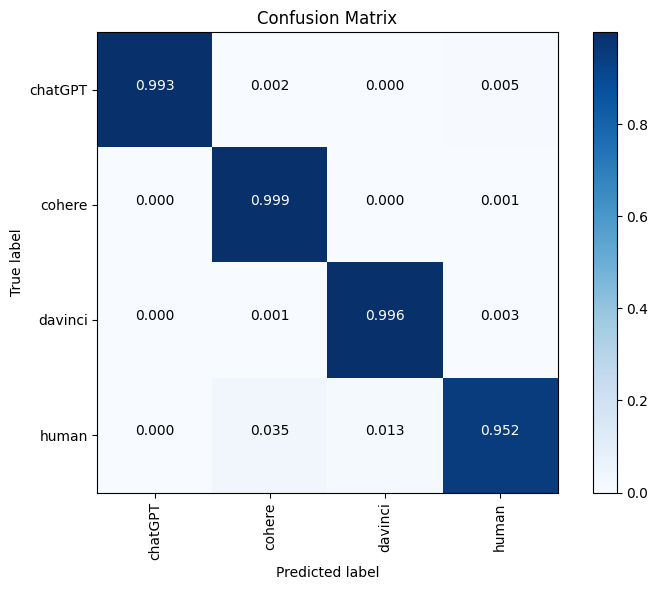


Classification report:

              precision    recall  f1-score   support

     chatGPT     1.0000    0.9933    0.9967      1200
      cohere     0.9638    0.9992    0.9812      1199
     davinci     0.9860    0.9965    0.9912      1134
       human     0.9913    0.9517    0.9711      1200

    accuracy                         0.9850      4733
   macro avg     0.9853    0.9852    0.9850      4733
weighted avg     0.9853    0.9850    0.9849      4733



In [35]:
evaluation(y_true, y_pred)

# Bert with Lora for every class

## Loading pretrained model

In [36]:
model_lora4 = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL,
    torch_dtype=torch.float32,
    num_labels=4
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data

In [37]:
train_lora4 = df_train
test_lora4 = df_test

## Finally, Lora

In [38]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [39]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=5,
    lora_alpha=1,
    lora_dropout=0.1
)

model_lora4 = get_peft_model(model_lora4, lora_config)
print_trainable_parameters(model_lora4)

trainable params: 685828 || all params: 82807304 || trainable%: 0.8282216264401024


## Training & evaluating the model

In [40]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [41]:
training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=num_train_epochs,)

trainer = Trainer(
    model=model_lora4,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_lora4,
    eval_dataset=test_lora4,
)

In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.417600,1.019662,0.690260
2,0.314900,0.847245,0.745193
3,0.272300,0.835143,0.750687


TrainOutput(global_step=7989, training_loss=0.42839129365927464, metrics={'train_runtime': 3210.977, 'train_samples_per_second': 39.795, 'train_steps_per_second': 2.488, 'total_flos': 1.7196772117856256e+16, 'train_loss': 0.42839129365927464, 'epoch': 3.0})

Accuracy: 0.7507
F1 Score: 0.7289


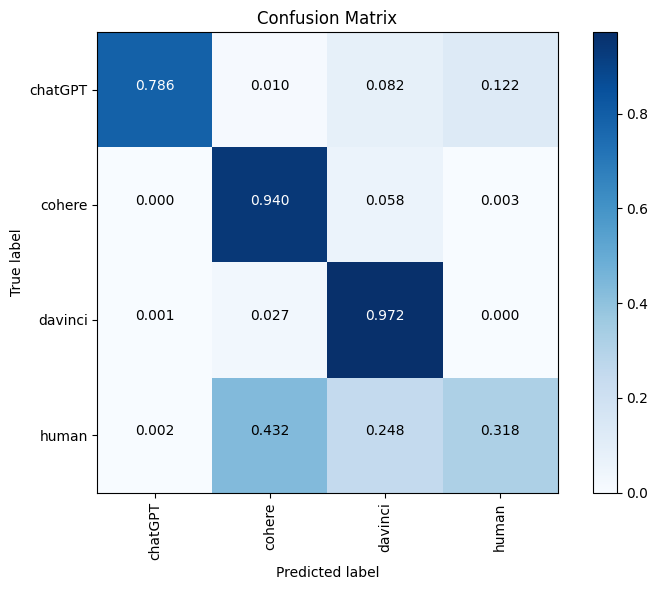


Classification report:

              precision    recall  f1-score   support

     chatGPT     0.9968    0.7858    0.8788      1200
      cohere     0.6673    0.9399    0.7805      1199
     davinci     0.7033    0.9718    0.8160      1134
       human     0.7175    0.3175    0.4402      1200

    accuracy                         0.7507      4733
   macro avg     0.7712    0.7538    0.7289      4733
weighted avg     0.7722    0.7507    0.7277      4733



In [43]:
predictions = trainer.predict(test_lora4)

# Extract the true labels from the model outputs
y_true = predictions.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = predictions.predictions.argmax(1)
evaluation(y_true, y_pred)

In [44]:
y_pred_pt = torch.from_numpy(predictions.predictions)
probs = nn.functional.softmax(y_pred_pt, dim=-1)

text = "ChatGPT is a large language model developed by OpenAI. It is trained on a massive dataset of text and is able to generate human-like responses to a wide range of prompts. It can be used for a variety of tasks such as language translation, text summarization, and conversation generation. It has been trained on a diverse set of internet text and is capable of understanding and generating text in a variety of languages and styles."
print(answer(text, model_lora4))

LABEL_2


# Bert with Lora for binary classification three times

## Model & Lora

In [45]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch",
    num_train_epochs=num_train_epochs,)

## ChatGPT vs Humans

In [46]:
model1 = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL,
    torch_dtype=torch.float32,
    num_labels=2
)
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=5,
    lora_alpha=1,
    lora_dropout=0.1
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model1 = get_peft_model(model1, lora_config)
print_trainable_parameters(model1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 684290 || all params: 82804228 || trainable%: 0.8263950000234288


In [47]:
df = pd.read_json("subtaskB_train.jsonl", lines=True)

df = df.where((df['model'] == 'chatGPT') | (df['model'] == 'human'))
df = df.dropna()
dataset = Dataset.from_pandas(df)

In [48]:
labels_list = np.unique(df[['model']])
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list.tolist())
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=1 - train_fraction, shuffle=True, stratify_by_column="label")
df_train = dataset['train']
df_test = dataset['test']

Casting the dataset:   0%|          | 0/23992 [00:00<?, ? examples/s]

In [49]:
df_train = df_train.map(lambda x: tokenize_function(x, tokenizer), batched=True)
df_test = df_test.map(lambda x: tokenize_function(x, tokenizer), batched=True)

Map:   0%|          | 0/21592 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [50]:
trainer_1 = Trainer(
    model=model1,
    args=training_args,
    train_dataset=df_train,
    eval_dataset=df_test,
    compute_metrics=compute_metrics,
)

In [52]:
trainer_1.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.031300,0.228467,0.934167
2,0.018100,0.207958,0.948333
3,0.017100,0.222409,0.945833


TrainOutput(global_step=4050, training_loss=0.024298789780816916, metrics={'train_runtime': 1633.8114, 'train_samples_per_second': 39.647, 'train_steps_per_second': 2.479, 'total_flos': 9377881931808768.0, 'train_loss': 0.024298789780816916, 'epoch': 3.0})

Accuracy: 0.9458
F1 Score: 0.9457


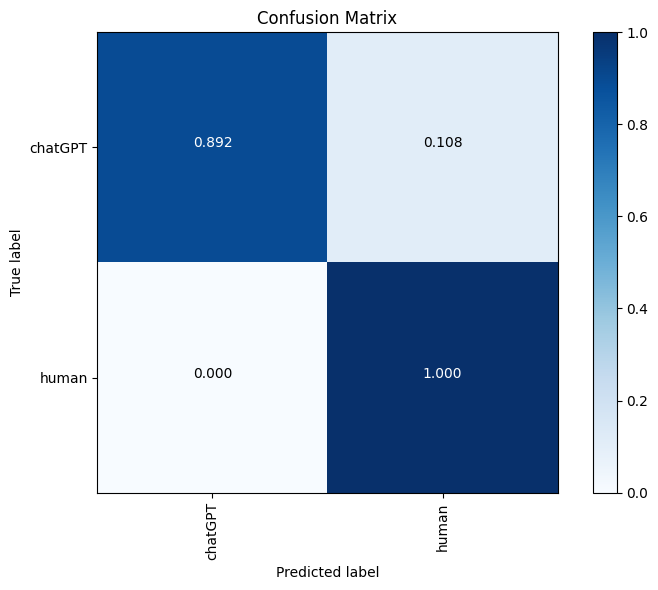


Classification report:

              precision    recall  f1-score   support

     chatGPT     1.0000    0.8917    0.9427      1200
       human     0.9023    1.0000    0.9486      1200

    accuracy                         0.9458      2400
   macro avg     0.9511    0.9458    0.9457      2400
weighted avg     0.9511    0.9458    0.9457      2400



In [53]:
predictions_1 = trainer_1.predict(df_test)
y_true_1 = predictions_1.label_ids
y_pred_1 = predictions_1.predictions.argmax(1)

evaluation(y_true_1, y_pred_1)

In [54]:
y_pred_pt = torch.from_numpy(predictions_1.predictions)
probs_1 = nn.functional.softmax(y_pred_pt, dim=-1)

text_human = "Are not the sane and the insane equal at night as the sane lie a dreaming? Are not all of us outside this hospital, who dream, more or less in the condition of those inside it, every night of our lives?"
text = "Once in a village, a wise old woman named Abigail united the villagers to overcome a great storm. With her guidance, they worked together, rebuilt, and emerged stronger, fostering a spirit of unity and hope. Abigail's wisdom and kindness were immortalized, and the village thrived."
print(answer(text, model1))
print(answer(text_human, model1))

LABEL_1
LABEL_0


## Cohere vs Humans

In [55]:
model2 = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL,
    torch_dtype=torch.float32,
    num_labels=2
)
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=5,
    lora_alpha=1,
    lora_dropout=0.1
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)
model2 = get_peft_model(model2, lora_config)
print_trainable_parameters(model2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 684290 || all params: 82804228 || trainable%: 0.8263950000234288


In [56]:
df = pd.read_json("subtaskB_train.jsonl", lines=True)

df = df.where((df['model'] == 'cohere') | (df['model'] == 'human'))
df = df.dropna()
dataset = Dataset.from_pandas(df)

labels_list = np.unique(df[['model']])

# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list.tolist())

# Casting label column to ClassLabel Object
dataset = dataset.class_encode_column('label')

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=1 - train_fraction, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
df_train = dataset['train']

# Extracting the testing data from the split dataset.
df_test = dataset['test']

Stringifying the column:   0%|          | 0/23333 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/23333 [00:00<?, ? examples/s]

In [57]:
df_train = df_train.map(lambda x: tokenize_function(x, tokenizer), batched=True)
df_test = df_test.map(lambda x: tokenize_function(x, tokenizer), batched=True)

Map:   0%|          | 0/20999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2334 [00:00<?, ? examples/s]

In [58]:
trainer_2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=df_train,
    eval_dataset=df_test,
    compute_metrics=compute_metrics,
)

In [59]:
trainer_2.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.090500,0.222479,0.922451
2,0.043800,0.218393,0.934019
3,0.030500,0.295017,0.915596


TrainOutput(global_step=3939, training_loss=0.08835839874159113, metrics={'train_runtime': 1583.556, 'train_samples_per_second': 39.782, 'train_steps_per_second': 2.487, 'total_flos': 8477477156155392.0, 'train_loss': 0.08835839874159113, 'epoch': 3.0})

Accuracy: 0.9156
F1 Score: 0.9153


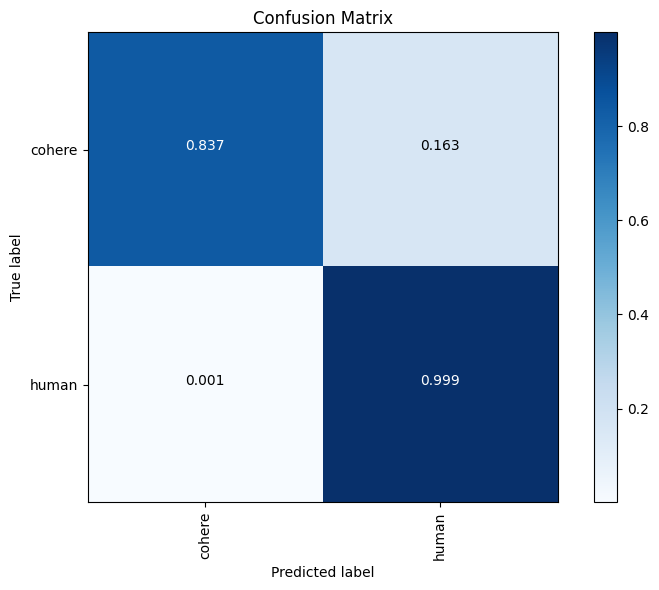


Classification report:

              precision    recall  f1-score   support

      cohere     0.9990    0.8367    0.9107      1200
       human     0.8525    0.9991    0.9200      1134

    accuracy                         0.9156      2334
   macro avg     0.9258    0.9179    0.9153      2334
weighted avg     0.9278    0.9156    0.9152      2334



In [60]:
predictions_2 = trainer_2.predict(df_test)
y_true_2 = predictions_2.label_ids
y_pred_2 = predictions_2.predictions.argmax(1)
evaluation(y_true_2, y_pred_2)

In [61]:
y_pred_pt = torch.from_numpy(predictions_2.predictions)
probs_2 = nn.functional.softmax(y_pred_pt, dim=-1)

text_human = "Are not the sane and the insane equal at night as the sane lie a dreaming? Are not all of us outside this hospital, who dream, more or less in the condition of those inside it, every night of our lives?"
text = "Once in a village, a wise old woman named Abigail united the villagers to overcome a great storm. With her guidance, they worked together, rebuilt, and emerged stronger, fostering a spirit of unity and hope. Abigail's wisdom and kindness were immortalized, and the village thrived."
print(answer(text, model2))
print(answer(text_human, model2))

LABEL_1
LABEL_1


## Davinci vs Humans

In [62]:
model3 = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL,
    torch_dtype=torch.float32,
    num_labels=2
)
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=5,
    lora_alpha=1,
    lora_dropout=0.1
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)
model3 = get_peft_model(model3, lora_config)
print_trainable_parameters(model3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 684290 || all params: 82804228 || trainable%: 0.8263950000234288


In [63]:
df = pd.read_json("subtaskB_train.jsonl", lines=True)

df = df.where((df['model'] == 'davinci') | (df['model'] == 'human'))
df = df.dropna()
dataset = Dataset.from_pandas(df)

labels_list = np.unique(df[['model']])

# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list.tolist())

# Casting label column to ClassLabel Object
dataset = dataset.class_encode_column('label')

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=1 - train_fraction, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
df_train = dataset['train']

# Extracting the testing data from the split dataset.
df_test = dataset['test']

Stringifying the column:   0%|          | 0/23996 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/23996 [00:00<?, ? examples/s]

In [64]:
df_train = df_train.map(lambda x: tokenize_function(x, tokenizer), batched=True)
df_test = df_test.map(lambda x: tokenize_function(x, tokenizer), batched=True)

Map:   0%|          | 0/21596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [65]:
trainer_3 = Trainer(
    model=model3,
    args=training_args,
    train_dataset=df_train,
    eval_dataset=df_test,
    compute_metrics=compute_metrics,
)

In [66]:
trainer_3.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.149800,0.301327,0.900000
2,0.081600,0.322647,0.910833
3,0.074900,0.278814,0.924167


TrainOutput(global_step=4050, training_loss=0.13162907200095095, metrics={'train_runtime': 1632.395, 'train_samples_per_second': 39.689, 'train_steps_per_second': 2.481, 'total_flos': 8718491197882368.0, 'train_loss': 0.13162907200095095, 'epoch': 3.0})

Accuracy: 0.9242
F1 Score: 0.9238


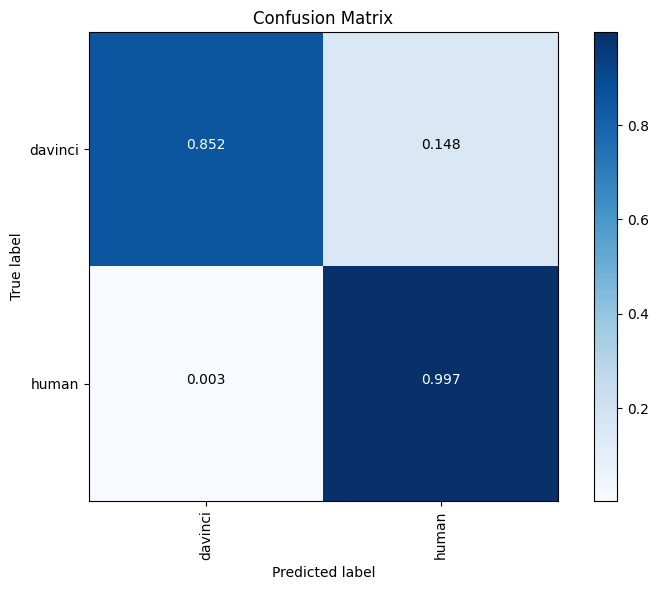


Classification report:

              precision    recall  f1-score   support

     davinci     0.9961    0.8517    0.9182      1200
       human     0.8705    0.9967    0.9293      1200

    accuracy                         0.9242      2400
   macro avg     0.9333    0.9242    0.9238      2400
weighted avg     0.9333    0.9242    0.9238      2400



In [67]:
predictions_3 = trainer_3.predict(df_test)
y_true_3 = predictions_3.label_ids
y_pred_3 = predictions_3.predictions.argmax(1)
evaluation(y_true_3, y_pred_3)

In [68]:
y_pred_pt = torch.from_numpy(predictions_3.predictions)
probs_3 = nn.functional.softmax(y_pred_pt, dim=-1)

text_human = "Are not the sane and the insane equal at night as the sane lie a dreaming? Are not all of us outside this hospital, who dream, more or less in the condition of those inside it, every night of our lives?"
text = "Once in a village, a wise old woman named Abigail united the villagers to overcome a great storm. With her guidance, they worked together, rebuilt, and emerged stronger, fostering a spirit of unity and hope. Abigail's wisdom and kindness were immortalized, and the village thrived."
print(answer(text, model3))
print(answer(text_human, model3))

LABEL_1
LABEL_1


In [69]:
def answer_all(text, model1, model2, model3):
    device = torch.device('cpu')
    model1 = model1.to(device)
    model2 = model2.to(device)
    model3 = model3.to(device)
    
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits1 = model1(**inputs).logits
        logits2 = model2(**inputs).logits
        logits3 = model3(**inputs).logits
        
    max_logits = max(logits1.max(), logits2.max(), logits3.max())
    predicted_class_id = max_logits.argmax().item()

    if (logits1.max() >= logits2.max() and logits1.max() >= logits3.max()):
        return (model1.config.id2label[predicted_class_id], 'model1')
    elif (logits2.max() >= logits1.max() and logits2.max() >= logits3.max()):
        return (model2.config.id2label[predicted_class_id], 'model2')
    return (model3.config.id2label[predicted_class_id], 'model3')

In [70]:
text_human = "Are not the sane and the insane equal at night as the sane lie a dreaming? Are not all of us outside this hospital, who dream, more or less in the condition of those inside it, every night of our lives?"
text = "Once in a village, a wise old woman named Abigail united the villagers to overcome a great storm. With her guidance, they worked together, rebuilt, and emerged stronger, fostering a spirit of unity and hope. Abigail's wisdom and kindness were immortalized, and the village thrived."
print(answer_all(text, model1, model2, model3)[0], answer_all(text, model1, model2, model3)[1])

LABEL_0 model1
